In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4012456, 1656)
(4012456, 8)
validation
(542352, 1656)
(542352, 8)
test
(574820, 1656)
(574820, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1656)]            0         


 dense (Dense)               (None, 2048)              3393536   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 6181768 (23.58 MB)


Trainable params: 6181768 (23.58 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/41 [..............................] - ETA: 9:29 - loss: 2.2000 - STD: 0.0834 - MAE: 0.2141

 2/41 [>.............................] - ETA: 27s - loss: 2.1433 - STD: 0.0613 - MAE: 0.2155 

 3/41 [=>............................] - ETA: 27s - loss: 2.1184 - STD: 0.0496 - MAE: 0.2162

 4/41 [=>............................] - ETA: 24s - loss: 2.1076 - STD: 0.0443 - MAE: 0.2166

 5/41 [==>...........................] - ETA: 24s - loss: 2.1024 - STD: 0.0427 - MAE: 0.2168

 6/41 [===>..........................] - ETA: 23s - loss: 2.0981 - STD: 0.0420 - MAE: 0.2168

 7/41 [====>.........................] - ETA: 22s - loss: 2.0935 - STD: 0.0414 - MAE: 0.2168

 8/41 [====>.........................] - ETA: 24s - loss: 2.0893 - STD: 0.0410 - MAE: 0.2168

 9/41 [=====>........................] - ETA: 23s - loss: 2.0858 - STD: 0.0408 - MAE: 0.2168

10/41 [======>.......................] - ETA: 22s - loss: 2.0830 - STD: 0.0407 - MAE: 0.2167

11/41 [=======>......................] - ETA: 21s - loss: 2.0808 - STD: 0.0406 - MAE: 0.2167

12/41 [=======>......................] - ETA: 20s - loss: 2.0789 - STD: 0.0406 - MAE: 0.2166

13/41 [========>.....................] - ETA: 21s - loss: 2.0772 - STD: 0.0405 - MAE: 0.2166

14/41 [=========>....................] - ETA: 21s - loss: 2.0760 - STD: 0.0404 - MAE: 0.2166

15/41 [=========>....................] - ETA: 21s - loss: 2.0749 - STD: 0.0401 - MAE: 0.2166

16/41 [==========>...................] - ETA: 20s - loss: 2.0738 - STD: 0.0398 - MAE: 0.2166

17/41 [===========>..................] - ETA: 19s - loss: 2.0727 - STD: 0.0394 - MAE: 0.2166

18/41 [============>.................] - ETA: 19s - loss: 2.0716 - STD: 0.0389 - MAE: 0.2166

19/41 [============>.................] - ETA: 18s - loss: 2.0705 - STD: 0.0383 - MAE: 0.2166

20/41 [=============>................] - ETA: 18s - loss: 2.0696 - STD: 0.0379 - MAE: 0.2167

21/41 [==============>...............] - ETA: 17s - loss: 2.0688 - STD: 0.0375 - MAE: 0.2167

22/41 [===============>..............] - ETA: 16s - loss: 2.0680 - STD: 0.0372 - MAE: 0.2167

23/41 [===============>..............] - ETA: 15s - loss: 2.0673 - STD: 0.0370 - MAE: 0.2167

24/41 [================>.............] - ETA: 14s - loss: 2.0667 - STD: 0.0369 - MAE: 0.2167

25/41 [=================>............] - ETA: 13s - loss: 2.0660 - STD: 0.0368 - MAE: 0.2167

26/41 [==================>...........] - ETA: 12s - loss: 2.0654 - STD: 0.0367 - MAE: 0.2167

27/41 [==================>...........] - ETA: 11s - loss: 2.0648 - STD: 0.0367 - MAE: 0.2166

28/41 [===================>..........] - ETA: 10s - loss: 2.0642 - STD: 0.0366 - MAE: 0.2166

29/41 [====================>.........] - ETA: 9s - loss: 2.0635 - STD: 0.0364 - MAE: 0.2166 

30/41 [====================>.........] - ETA: 9s - loss: 2.0629 - STD: 0.0362 - MAE: 0.2166

31/41 [=====================>........] - ETA: 8s - loss: 2.0623 - STD: 0.0360 - MAE: 0.2166

32/41 [======================>.......] - ETA: 7s - loss: 2.0616 - STD: 0.0359 - MAE: 0.2166

33/41 [=======================>......] - ETA: 6s - loss: 2.0608 - STD: 0.0358 - MAE: 0.2166

34/41 [=======================>......] - ETA: 5s - loss: 2.0600 - STD: 0.0357 - MAE: 0.2166

35/41 [========================>.....] - ETA: 4s - loss: 2.0591 - STD: 0.0356 - MAE: 0.2166

36/41 [=========================>....] - ETA: 4s - loss: 2.0581 - STD: 0.0356 - MAE: 0.2165

37/41 [==========================>...] - ETA: 3s - loss: 2.0569 - STD: 0.0356 - MAE: 0.2165

38/41 [==========================>...] - ETA: 2s - loss: 2.0567 - STD: 0.0357 - MAE: 0.2164

39/41 [===========================>..] - ETA: 1s - loss: 2.0552 - STD: 0.0358 - MAE: 0.2164

40/41 [============================>.] - ETA: 0s - loss: 2.0534 - STD: 0.0360 - MAE: 0.2163

41/41 [==============================] - ETA: 0s - loss: 2.0515 - STD: 0.0363 - MAE: 0.2162

41/41 [==============================] - 57s 1s/step - loss: 2.0515 - STD: 0.0363 - MAE: 0.2162 - val_loss: 1.9337 - val_STD: 0.0475 - val_MAE: 0.2114


Epoch 2/10000


 1/41 [..............................] - ETA: 58s - loss: 1.9640 - STD: 0.0483 - MAE: 0.2124

 2/41 [>.............................] - ETA: 27s - loss: 1.9571 - STD: 0.0504 - MAE: 0.2120

 3/41 [=>............................] - ETA: 25s - loss: 1.9498 - STD: 0.0517 - MAE: 0.2116

 4/41 [=>............................] - ETA: 28s - loss: 1.9424 - STD: 0.0535 - MAE: 0.2112

 5/41 [==>...........................] - ETA: 32s - loss: 1.9361 - STD: 0.0544 - MAE: 0.2109

 6/41 [===>..........................] - ETA: 29s - loss: 1.9309 - STD: 0.0569 - MAE: 0.2105

 7/41 [====>.........................] - ETA: 30s - loss: 1.9238 - STD: 0.0582 - MAE: 0.2101

 8/41 [====>.........................] - ETA: 28s - loss: 1.9178 - STD: 0.0593 - MAE: 0.2098

 9/41 [=====>........................] - ETA: 28s - loss: 1.9122 - STD: 0.0613 - MAE: 0.2094

10/41 [======>.......................] - ETA: 26s - loss: 1.9059 - STD: 0.0626 - MAE: 0.2091

11/41 [=======>......................] - ETA: 26s - loss: 1.9006 - STD: 0.0636 - MAE: 0.2088

12/41 [=======>......................] - ETA: 25s - loss: 1.8955 - STD: 0.0652 - MAE: 0.2085

13/41 [========>.....................] - ETA: 24s - loss: 1.8902 - STD: 0.0661 - MAE: 0.2082

14/41 [=========>....................] - ETA: 25s - loss: 1.8848 - STD: 0.0670 - MAE: 0.2080

15/41 [=========>....................] - ETA: 23s - loss: 1.8804 - STD: 0.0684 - MAE: 0.2077

16/41 [==========>...................] - ETA: 23s - loss: 1.8766 - STD: 0.0690 - MAE: 0.2075

17/41 [===========>..................] - ETA: 22s - loss: 1.8721 - STD: 0.0701 - MAE: 0.2072

18/41 [============>.................] - ETA: 21s - loss: 1.8672 - STD: 0.0710 - MAE: 0.2069

19/41 [============>.................] - ETA: 21s - loss: 1.8630 - STD: 0.0717 - MAE: 0.2067

20/41 [=============>................] - ETA: 20s - loss: 1.8593 - STD: 0.0728 - MAE: 0.2065

21/41 [==============>...............] - ETA: 19s - loss: 1.8554 - STD: 0.0734 - MAE: 0.2063

22/41 [===============>..............] - ETA: 18s - loss: 1.8512 - STD: 0.0742 - MAE: 0.2060

23/41 [===============>..............] - ETA: 17s - loss: 1.8473 - STD: 0.0750 - MAE: 0.2058

24/41 [================>.............] - ETA: 15s - loss: 1.8437 - STD: 0.0756 - MAE: 0.2056

25/41 [=================>............] - ETA: 14s - loss: 1.8406 - STD: 0.0765 - MAE: 0.2054

26/41 [==================>...........] - ETA: 14s - loss: 1.8376 - STD: 0.0769 - MAE: 0.2053

27/41 [==================>...........] - ETA: 12s - loss: 1.8341 - STD: 0.0776 - MAE: 0.2051

28/41 [===================>..........] - ETA: 12s - loss: 1.8307 - STD: 0.0782 - MAE: 0.2049

29/41 [====================>.........] - ETA: 11s - loss: 1.8278 - STD: 0.0787 - MAE: 0.2047

30/41 [====================>.........] - ETA: 10s - loss: 1.8248 - STD: 0.0793 - MAE: 0.2045

31/41 [=====================>........] - ETA: 9s - loss: 1.8216 - STD: 0.0798 - MAE: 0.2044 

32/41 [======================>.......] - ETA: 8s - loss: 1.8185 - STD: 0.0803 - MAE: 0.2042

33/41 [=======================>......] - ETA: 6s - loss: 1.8182 - STD: 0.0809 - MAE: 0.2040

34/41 [=======================>......] - ETA: 6s - loss: 1.8153 - STD: 0.0813 - MAE: 0.2039

35/41 [========================>.....] - ETA: 5s - loss: 1.8122 - STD: 0.0818 - MAE: 0.2037

36/41 [=========================>....] - ETA: 4s - loss: 1.8092 - STD: 0.0823 - MAE: 0.2035

37/41 [==========================>...] - ETA: 3s - loss: 1.8064 - STD: 0.0827 - MAE: 0.2034

38/41 [==========================>...] - ETA: 2s - loss: 1.8038 - STD: 0.0832 - MAE: 0.2032

39/41 [===========================>..] - ETA: 1s - loss: 1.8012 - STD: 0.0835 - MAE: 0.2031

40/41 [============================>.] - ETA: 0s - loss: 1.7984 - STD: 0.0840 - MAE: 0.2030

41/41 [==============================] - ETA: 0s - loss: 1.7955 - STD: 0.0844 - MAE: 0.2028

41/41 [==============================] - 42s 1s/step - loss: 1.7955 - STD: 0.0844 - MAE: 0.2028 - val_loss: 1.6384 - val_STD: 0.1044 - val_MAE: 0.1949


Epoch 3/10000


 1/41 [..............................] - ETA: 10s - loss: 1.6844 - STD: 0.0992 - MAE: 0.1970

 2/41 [>.............................] - ETA: 1:05 - loss: 1.6803 - STD: 0.1014 - MAE: 0.1965

 3/41 [=>............................] - ETA: 52s - loss: 1.6800 - STD: 0.1010 - MAE: 0.1965 

 4/41 [=>............................] - ETA: 50s - loss: 1.6770 - STD: 0.1017 - MAE: 0.1963

 5/41 [==>...........................] - ETA: 42s - loss: 1.6722 - STD: 0.1014 - MAE: 0.1962

 6/41 [===>..........................] - ETA: 41s - loss: 1.6677 - STD: 0.1018 - MAE: 0.1960

 7/41 [====>.........................] - ETA: 39s - loss: 1.6623 - STD: 0.1019 - MAE: 0.1958

 8/41 [====>.........................] - ETA: 37s - loss: 1.6563 - STD: 0.1022 - MAE: 0.1955

 9/41 [=====>........................] - ETA: 36s - loss: 1.6509 - STD: 0.1025 - MAE: 0.1952

10/41 [======>.......................] - ETA: 35s - loss: 1.6448 - STD: 0.1029 - MAE: 0.1949

11/41 [=======>......................] - ETA: 33s - loss: 1.6394 - STD: 0.1033 - MAE: 0.1946

12/41 [=======>......................] - ETA: 32s - loss: 1.6341 - STD: 0.1036 - MAE: 0.1943

13/41 [========>.....................] - ETA: 31s - loss: 1.6322 - STD: 0.1044 - MAE: 0.1941

14/41 [=========>....................] - ETA: 29s - loss: 1.6297 - STD: 0.1047 - MAE: 0.1939

15/41 [=========>....................] - ETA: 28s - loss: 1.6216 - STD: 0.1052 - MAE: 0.1935

16/41 [==========>...................] - ETA: 26s - loss: 1.6157 - STD: 0.1060 - MAE: 0.1931

17/41 [===========>..................] - ETA: 25s - loss: 1.6099 - STD: 0.1066 - MAE: 0.1927

18/41 [============>.................] - ETA: 24s - loss: 1.6017 - STD: 0.1074 - MAE: 0.1922

19/41 [============>.................] - ETA: 22s - loss: 1.5958 - STD: 0.1084 - MAE: 0.1918

20/41 [=============>................] - ETA: 21s - loss: 1.5884 - STD: 0.1093 - MAE: 0.1913

21/41 [==============>...............] - ETA: 20s - loss: 1.5822 - STD: 0.1101 - MAE: 0.1909

22/41 [===============>..............] - ETA: 19s - loss: 1.5752 - STD: 0.1110 - MAE: 0.1904

23/41 [===============>..............] - ETA: 18s - loss: 1.5688 - STD: 0.1121 - MAE: 0.1899

24/41 [================>.............] - ETA: 17s - loss: 1.5621 - STD: 0.1130 - MAE: 0.1894

25/41 [=================>............] - ETA: 16s - loss: 1.5558 - STD: 0.1139 - MAE: 0.1890

26/41 [==================>...........] - ETA: 15s - loss: 1.5504 - STD: 0.1149 - MAE: 0.1885

27/41 [==================>...........] - ETA: 14s - loss: 1.5466 - STD: 0.1158 - MAE: 0.1881

28/41 [===================>..........] - ETA: 13s - loss: 1.5418 - STD: 0.1167 - MAE: 0.1877

29/41 [====================>.........] - ETA: 12s - loss: 1.5363 - STD: 0.1176 - MAE: 0.1873

30/41 [====================>.........] - ETA: 11s - loss: 1.5307 - STD: 0.1185 - MAE: 0.1868

31/41 [=====================>........] - ETA: 10s - loss: 1.5256 - STD: 0.1193 - MAE: 0.1864

32/41 [======================>.......] - ETA: 9s - loss: 1.5211 - STD: 0.1201 - MAE: 0.1861 

33/41 [=======================>......] - ETA: 8s - loss: 1.5161 - STD: 0.1208 - MAE: 0.1857

34/41 [=======================>......] - ETA: 6s - loss: 1.5111 - STD: 0.1215 - MAE: 0.1853

35/41 [========================>.....] - ETA: 5s - loss: 1.5065 - STD: 0.1222 - MAE: 0.1849

36/41 [=========================>....] - ETA: 4s - loss: 1.5021 - STD: 0.1229 - MAE: 0.1846

37/41 [==========================>...] - ETA: 3s - loss: 1.4978 - STD: 0.1236 - MAE: 0.1842

38/41 [==========================>...] - ETA: 2s - loss: 1.4936 - STD: 0.1243 - MAE: 0.1838

39/41 [===========================>..] - ETA: 1s - loss: 1.4894 - STD: 0.1249 - MAE: 0.1835

40/41 [============================>.] - ETA: 0s - loss: 1.4855 - STD: 0.1255 - MAE: 0.1832

41/41 [==============================] - ETA: 0s - loss: 1.4817 - STD: 0.1261 - MAE: 0.1829

41/41 [==============================] - 46s 1s/step - loss: 1.4817 - STD: 0.1261 - MAE: 0.1829 - val_loss: 1.2865 - val_STD: 0.1527 - val_MAE: 0.1678


Epoch 4/10000


 1/41 [..............................] - ETA: 56s - loss: 1.3233 - STD: 0.1502 - MAE: 0.1695

 2/41 [>.............................] - ETA: 27s - loss: 1.3242 - STD: 0.1504 - MAE: 0.1695

 3/41 [=>............................] - ETA: 32s - loss: 1.3224 - STD: 0.1506 - MAE: 0.1693

 4/41 [=>............................] - ETA: 31s - loss: 1.3207 - STD: 0.1514 - MAE: 0.1690

 5/41 [==>...........................] - ETA: 29s - loss: 1.3192 - STD: 0.1519 - MAE: 0.1687

 6/41 [===>..........................] - ETA: 29s - loss: 1.3180 - STD: 0.1522 - MAE: 0.1686

 7/41 [====>.........................] - ETA: 30s - loss: 1.3172 - STD: 0.1523 - MAE: 0.1685

 8/41 [====>.........................] - ETA: 30s - loss: 1.3163 - STD: 0.1526 - MAE: 0.1683

 9/41 [=====>........................] - ETA: 29s - loss: 1.3153 - STD: 0.1528 - MAE: 0.1682

10/41 [======>.......................] - ETA: 29s - loss: 1.3142 - STD: 0.1530 - MAE: 0.1681

11/41 [=======>......................] - ETA: 28s - loss: 1.3132 - STD: 0.1534 - MAE: 0.1679

12/41 [=======>......................] - ETA: 28s - loss: 1.3117 - STD: 0.1538 - MAE: 0.1677

13/41 [========>.....................] - ETA: 27s - loss: 1.3106 - STD: 0.1540 - MAE: 0.1676

14/41 [=========>....................] - ETA: 26s - loss: 1.3092 - STD: 0.1542 - MAE: 0.1674

15/41 [=========>....................] - ETA: 25s - loss: 1.3085 - STD: 0.1544 - MAE: 0.1673

16/41 [==========>...................] - ETA: 24s - loss: 1.3080 - STD: 0.1546 - MAE: 0.1672

17/41 [===========>..................] - ETA: 23s - loss: 1.3081 - STD: 0.1548 - MAE: 0.1671

18/41 [============>.................] - ETA: 22s - loss: 1.3094 - STD: 0.1552 - MAE: 0.1671

19/41 [============>.................] - ETA: 21s - loss: 1.3098 - STD: 0.1554 - MAE: 0.1670

20/41 [=============>................] - ETA: 20s - loss: 1.3088 - STD: 0.1556 - MAE: 0.1669

21/41 [==============>...............] - ETA: 20s - loss: 1.3075 - STD: 0.1558 - MAE: 0.1668

22/41 [===============>..............] - ETA: 19s - loss: 1.3071 - STD: 0.1559 - MAE: 0.1667

23/41 [===============>..............] - ETA: 18s - loss: 1.3068 - STD: 0.1561 - MAE: 0.1666

24/41 [================>.............] - ETA: 17s - loss: 1.3058 - STD: 0.1563 - MAE: 0.1665

25/41 [=================>............] - ETA: 16s - loss: 1.3046 - STD: 0.1565 - MAE: 0.1664

26/41 [==================>...........] - ETA: 15s - loss: 1.3038 - STD: 0.1567 - MAE: 0.1663

27/41 [==================>...........] - ETA: 14s - loss: 1.3030 - STD: 0.1569 - MAE: 0.1662

28/41 [===================>..........] - ETA: 13s - loss: 1.3015 - STD: 0.1571 - MAE: 0.1660

29/41 [====================>.........] - ETA: 11s - loss: 1.3013 - STD: 0.1573 - MAE: 0.1659

30/41 [====================>.........] - ETA: 10s - loss: 1.3003 - STD: 0.1576 - MAE: 0.1658

31/41 [=====================>........] - ETA: 9s - loss: 1.2988 - STD: 0.1578 - MAE: 0.1656 

32/41 [======================>.......] - ETA: 8s - loss: 1.2977 - STD: 0.1580 - MAE: 0.1655

33/41 [=======================>......] - ETA: 7s - loss: 1.2966 - STD: 0.1582 - MAE: 0.1654

34/41 [=======================>......] - ETA: 6s - loss: 1.2953 - STD: 0.1584 - MAE: 0.1652

35/41 [========================>.....] - ETA: 5s - loss: 1.2942 - STD: 0.1585 - MAE: 0.1651

36/41 [=========================>....] - ETA: 4s - loss: 1.2932 - STD: 0.1587 - MAE: 0.1650

37/41 [==========================>...] - ETA: 3s - loss: 1.2921 - STD: 0.1589 - MAE: 0.1649

38/41 [==========================>...] - ETA: 3s - loss: 1.2907 - STD: 0.1591 - MAE: 0.1648

39/41 [===========================>..] - ETA: 2s - loss: 1.2896 - STD: 0.1593 - MAE: 0.1647

40/41 [============================>.] - ETA: 1s - loss: 1.2885 - STD: 0.1595 - MAE: 0.1646

41/41 [==============================] - ETA: 0s - loss: 1.2874 - STD: 0.1596 - MAE: 0.1644

41/41 [==============================] - 48s 1s/step - loss: 1.2874 - STD: 0.1596 - MAE: 0.1644 - val_loss: 1.2220 - val_STD: 0.1714 - val_MAE: 0.1580


Epoch 5/10000


 1/41 [..............................] - ETA: 1:05 - loss: 1.2516 - STD: 0.1678 - MAE: 0.1599

 2/41 [>.............................] - ETA: 42s - loss: 1.2497 - STD: 0.1671 - MAE: 0.1599 

 3/41 [=>............................] - ETA: 43s - loss: 1.2459 - STD: 0.1674 - MAE: 0.1596

 4/41 [=>............................] - ETA: 41s - loss: 1.2429 - STD: 0.1675 - MAE: 0.1595

 5/41 [==>...........................] - ETA: 39s - loss: 1.2411 - STD: 0.1674 - MAE: 0.1594

 6/41 [===>..........................] - ETA: 38s - loss: 1.2398 - STD: 0.1678 - MAE: 0.1592

 7/41 [====>.........................] - ETA: 37s - loss: 1.2389 - STD: 0.1679 - MAE: 0.1591

 8/41 [====>.........................] - ETA: 35s - loss: 1.2377 - STD: 0.1682 - MAE: 0.1590

 9/41 [=====>........................] - ETA: 34s - loss: 1.2361 - STD: 0.1683 - MAE: 0.1589

10/41 [======>.......................] - ETA: 33s - loss: 1.2351 - STD: 0.1685 - MAE: 0.1588

11/41 [=======>......................] - ETA: 32s - loss: 1.2337 - STD: 0.1687 - MAE: 0.1586

12/41 [=======>......................] - ETA: 31s - loss: 1.2322 - STD: 0.1689 - MAE: 0.1585

13/41 [========>.....................] - ETA: 30s - loss: 1.2308 - STD: 0.1690 - MAE: 0.1584

14/41 [=========>....................] - ETA: 29s - loss: 1.2299 - STD: 0.1692 - MAE: 0.1583

15/41 [=========>....................] - ETA: 28s - loss: 1.2293 - STD: 0.1694 - MAE: 0.1582

16/41 [==========>...................] - ETA: 27s - loss: 1.2284 - STD: 0.1696 - MAE: 0.1581

17/41 [===========>..................] - ETA: 25s - loss: 1.2274 - STD: 0.1698 - MAE: 0.1579

18/41 [============>.................] - ETA: 24s - loss: 1.2272 - STD: 0.1699 - MAE: 0.1579

19/41 [============>.................] - ETA: 23s - loss: 1.2302 - STD: 0.1702 - MAE: 0.1579

20/41 [=============>................] - ETA: 22s - loss: 1.2367 - STD: 0.1701 - MAE: 0.1582

21/41 [==============>...............] - ETA: 21s - loss: 1.2397 - STD: 0.1704 - MAE: 0.1583

22/41 [===============>..............] - ETA: 20s - loss: 1.2382 - STD: 0.1706 - MAE: 0.1581

23/41 [===============>..............] - ETA: 19s - loss: 1.2395 - STD: 0.1706 - MAE: 0.1582

24/41 [================>.............] - ETA: 18s - loss: 1.2399 - STD: 0.1707 - MAE: 0.1581

25/41 [=================>............] - ETA: 17s - loss: 1.2384 - STD: 0.1709 - MAE: 0.1580

26/41 [==================>...........] - ETA: 16s - loss: 1.2389 - STD: 0.1709 - MAE: 0.1580

27/41 [==================>...........] - ETA: 15s - loss: 1.2377 - STD: 0.1710 - MAE: 0.1579

28/41 [===================>..........] - ETA: 14s - loss: 1.2372 - STD: 0.1711 - MAE: 0.1579

29/41 [====================>.........] - ETA: 13s - loss: 1.2365 - STD: 0.1711 - MAE: 0.1578

30/41 [====================>.........] - ETA: 12s - loss: 1.2355 - STD: 0.1712 - MAE: 0.1577

31/41 [=====================>........] - ETA: 10s - loss: 1.2351 - STD: 0.1713 - MAE: 0.1577

32/41 [======================>.......] - ETA: 9s - loss: 1.2339 - STD: 0.1714 - MAE: 0.1576 

33/41 [=======================>......] - ETA: 8s - loss: 1.2334 - STD: 0.1714 - MAE: 0.1576

34/41 [=======================>......] - ETA: 7s - loss: 1.2322 - STD: 0.1716 - MAE: 0.1575

35/41 [========================>.....] - ETA: 6s - loss: 1.2315 - STD: 0.1718 - MAE: 0.1574

36/41 [=========================>....] - ETA: 5s - loss: 1.2306 - STD: 0.1718 - MAE: 0.1573

37/41 [==========================>...] - ETA: 4s - loss: 1.2296 - STD: 0.1719 - MAE: 0.1572

38/41 [==========================>...] - ETA: 3s - loss: 1.2290 - STD: 0.1721 - MAE: 0.1571

39/41 [===========================>..] - ETA: 2s - loss: 1.2278 - STD: 0.1722 - MAE: 0.1570

40/41 [============================>.] - ETA: 1s - loss: 1.2277 - STD: 0.1722 - MAE: 0.1570

41/41 [==============================] - ETA: 0s - loss: 1.2266 - STD: 0.1723 - MAE: 0.1569

41/41 [==============================] - 50s 1s/step - loss: 1.2266 - STD: 0.1723 - MAE: 0.1569 - val_loss: 1.1799 - val_STD: 0.1829 - val_MAE: 0.1512


Epoch 6/10000


 1/41 [..............................] - ETA: 1:05 - loss: 1.1940 - STD: 0.1779 - MAE: 0.1536

 2/41 [>.............................] - ETA: 44s - loss: 1.1917 - STD: 0.1775 - MAE: 0.1536 

 3/41 [=>............................] - ETA: 41s - loss: 1.1942 - STD: 0.1769 - MAE: 0.1539

 4/41 [=>............................] - ETA: 38s - loss: 1.1968 - STD: 0.1772 - MAE: 0.1539

 5/41 [==>...........................] - ETA: 37s - loss: 1.1958 - STD: 0.1775 - MAE: 0.1538

 6/41 [===>..........................] - ETA: 36s - loss: 1.1956 - STD: 0.1776 - MAE: 0.1537

 7/41 [====>.........................] - ETA: 36s - loss: 1.1935 - STD: 0.1775 - MAE: 0.1536

 8/41 [====>.........................] - ETA: 34s - loss: 1.1911 - STD: 0.1775 - MAE: 0.1535

 9/41 [=====>........................] - ETA: 33s - loss: 1.1900 - STD: 0.1776 - MAE: 0.1534

10/41 [======>.......................] - ETA: 32s - loss: 1.1896 - STD: 0.1776 - MAE: 0.1534

11/41 [=======>......................] - ETA: 31s - loss: 1.1900 - STD: 0.1777 - MAE: 0.1534

12/41 [=======>......................] - ETA: 30s - loss: 1.1891 - STD: 0.1777 - MAE: 0.1533

13/41 [========>.....................] - ETA: 29s - loss: 1.1872 - STD: 0.1779 - MAE: 0.1532

14/41 [=========>....................] - ETA: 28s - loss: 1.1853 - STD: 0.1780 - MAE: 0.1530

15/41 [=========>....................] - ETA: 27s - loss: 1.1844 - STD: 0.1781 - MAE: 0.1529

16/41 [==========>...................] - ETA: 26s - loss: 1.1832 - STD: 0.1782 - MAE: 0.1528

17/41 [===========>..................] - ETA: 25s - loss: 1.1819 - STD: 0.1783 - MAE: 0.1527

18/41 [============>.................] - ETA: 24s - loss: 1.1805 - STD: 0.1784 - MAE: 0.1526

19/41 [============>.................] - ETA: 23s - loss: 1.1792 - STD: 0.1785 - MAE: 0.1525

20/41 [=============>................] - ETA: 21s - loss: 1.1781 - STD: 0.1786 - MAE: 0.1524

21/41 [==============>...............] - ETA: 20s - loss: 1.1770 - STD: 0.1787 - MAE: 0.1523

22/41 [===============>..............] - ETA: 19s - loss: 1.1762 - STD: 0.1787 - MAE: 0.1523

23/41 [===============>..............] - ETA: 18s - loss: 1.1759 - STD: 0.1789 - MAE: 0.1522

24/41 [================>.............] - ETA: 17s - loss: 1.1755 - STD: 0.1790 - MAE: 0.1521

25/41 [=================>............] - ETA: 16s - loss: 1.1753 - STD: 0.1791 - MAE: 0.1521

26/41 [==================>...........] - ETA: 15s - loss: 1.1752 - STD: 0.1792 - MAE: 0.1520

27/41 [==================>...........] - ETA: 14s - loss: 1.1749 - STD: 0.1794 - MAE: 0.1520

28/41 [===================>..........] - ETA: 13s - loss: 1.1741 - STD: 0.1795 - MAE: 0.1519

29/41 [====================>.........] - ETA: 12s - loss: 1.1730 - STD: 0.1796 - MAE: 0.1518

30/41 [====================>.........] - ETA: 11s - loss: 1.1720 - STD: 0.1797 - MAE: 0.1517

31/41 [=====================>........] - ETA: 9s - loss: 1.1718 - STD: 0.1798 - MAE: 0.1516 

32/41 [======================>.......] - ETA: 8s - loss: 1.1707 - STD: 0.1799 - MAE: 0.1515

33/41 [=======================>......] - ETA: 8s - loss: 1.1695 - STD: 0.1800 - MAE: 0.1514

34/41 [=======================>......] - ETA: 7s - loss: 1.1684 - STD: 0.1801 - MAE: 0.1513

35/41 [========================>.....] - ETA: 6s - loss: 1.1674 - STD: 0.1802 - MAE: 0.1512

36/41 [=========================>....] - ETA: 5s - loss: 1.1666 - STD: 0.1803 - MAE: 0.1511

37/41 [==========================>...] - ETA: 4s - loss: 1.1656 - STD: 0.1804 - MAE: 0.1511

38/41 [==========================>...] - ETA: 3s - loss: 1.1647 - STD: 0.1805 - MAE: 0.1510

39/41 [===========================>..] - ETA: 2s - loss: 1.1640 - STD: 0.1806 - MAE: 0.1509

40/41 [============================>.] - ETA: 1s - loss: 1.1638 - STD: 0.1807 - MAE: 0.1508

41/41 [==============================] - ETA: 0s - loss: 1.1657 - STD: 0.1809 - MAE: 0.1509

41/41 [==============================] - 47s 1s/step - loss: 1.1657 - STD: 0.1809 - MAE: 0.1509 - val_loss: 1.3056 - val_STD: 0.1925 - val_MAE: 0.1535


Epoch 7/10000


 1/41 [..............................] - ETA: 1:06 - loss: 1.3282 - STD: 0.1879 - MAE: 0.1563

 2/41 [>.............................] - ETA: 35s - loss: 1.3086 - STD: 0.1887 - MAE: 0.1549 

 3/41 [=>............................] - ETA: 40s - loss: 1.2532 - STD: 0.1882 - MAE: 0.1524

 4/41 [=>............................] - ETA: 38s - loss: 1.2430 - STD: 0.1887 - MAE: 0.1518

 5/41 [==>...........................] - ETA: 37s - loss: 1.2421 - STD: 0.1884 - MAE: 0.1518

 6/41 [===>..........................] - ETA: 36s - loss: 1.2299 - STD: 0.1876 - MAE: 0.1516

 7/41 [====>.........................] - ETA: 34s - loss: 1.2263 - STD: 0.1870 - MAE: 0.1516

 8/41 [====>.........................] - ETA: 33s - loss: 1.2201 - STD: 0.1867 - MAE: 0.1514

 9/41 [=====>........................] - ETA: 32s - loss: 1.2117 - STD: 0.1863 - MAE: 0.1512

10/41 [======>.......................] - ETA: 31s - loss: 1.2094 - STD: 0.1860 - MAE: 0.1512

11/41 [=======>......................] - ETA: 30s - loss: 1.2037 - STD: 0.1855 - MAE: 0.1511

12/41 [=======>......................] - ETA: 29s - loss: 1.1997 - STD: 0.1853 - MAE: 0.1509

13/41 [========>.....................] - ETA: 28s - loss: 1.1956 - STD: 0.1854 - MAE: 0.1507

14/41 [=========>....................] - ETA: 26s - loss: 1.1922 - STD: 0.1853 - MAE: 0.1506

15/41 [=========>....................] - ETA: 25s - loss: 1.1887 - STD: 0.1852 - MAE: 0.1505

16/41 [==========>...................] - ETA: 24s - loss: 1.1855 - STD: 0.1852 - MAE: 0.1503

17/41 [===========>..................] - ETA: 23s - loss: 1.1825 - STD: 0.1852 - MAE: 0.1502

18/41 [============>.................] - ETA: 22s - loss: 1.1798 - STD: 0.1853 - MAE: 0.1500

19/41 [============>.................] - ETA: 21s - loss: 1.1774 - STD: 0.1853 - MAE: 0.1499

20/41 [=============>................] - ETA: 20s - loss: 1.1750 - STD: 0.1852 - MAE: 0.1498

21/41 [==============>...............] - ETA: 19s - loss: 1.1731 - STD: 0.1851 - MAE: 0.1497

22/41 [===============>..............] - ETA: 18s - loss: 1.1704 - STD: 0.1851 - MAE: 0.1496

23/41 [===============>..............] - ETA: 17s - loss: 1.1688 - STD: 0.1852 - MAE: 0.1495

24/41 [================>.............] - ETA: 16s - loss: 1.1667 - STD: 0.1852 - MAE: 0.1494

25/41 [=================>............] - ETA: 15s - loss: 1.1650 - STD: 0.1852 - MAE: 0.1493

26/41 [==================>...........] - ETA: 14s - loss: 1.1631 - STD: 0.1852 - MAE: 0.1492

27/41 [==================>...........] - ETA: 13s - loss: 1.1613 - STD: 0.1853 - MAE: 0.1491

28/41 [===================>..........] - ETA: 12s - loss: 1.1596 - STD: 0.1853 - MAE: 0.1490

29/41 [====================>.........] - ETA: 11s - loss: 1.1580 - STD: 0.1854 - MAE: 0.1488

30/41 [====================>.........] - ETA: 10s - loss: 1.1565 - STD: 0.1854 - MAE: 0.1487

31/41 [=====================>........] - ETA: 9s - loss: 1.1550 - STD: 0.1855 - MAE: 0.1486 

32/41 [======================>.......] - ETA: 8s - loss: 1.1534 - STD: 0.1856 - MAE: 0.1485

33/41 [=======================>......] - ETA: 7s - loss: 1.1520 - STD: 0.1857 - MAE: 0.1484

34/41 [=======================>......] - ETA: 6s - loss: 1.1506 - STD: 0.1858 - MAE: 0.1483

35/41 [========================>.....] - ETA: 5s - loss: 1.1493 - STD: 0.1859 - MAE: 0.1482

36/41 [=========================>....] - ETA: 4s - loss: 1.1491 - STD: 0.1860 - MAE: 0.1481

37/41 [==========================>...] - ETA: 3s - loss: 1.1479 - STD: 0.1861 - MAE: 0.1480

38/41 [==========================>...] - ETA: 2s - loss: 1.1467 - STD: 0.1862 - MAE: 0.1479

39/41 [===========================>..] - ETA: 1s - loss: 1.1455 - STD: 0.1863 - MAE: 0.1478

40/41 [============================>.] - ETA: 0s - loss: 1.1443 - STD: 0.1864 - MAE: 0.1477

41/41 [==============================] - ETA: 0s - loss: 1.1432 - STD: 0.1865 - MAE: 0.1476

41/41 [==============================] - 45s 1s/step - loss: 1.1432 - STD: 0.1865 - MAE: 0.1476 - val_loss: 1.1065 - val_STD: 0.1961 - val_MAE: 0.1420


Epoch 8/10000


 1/41 [..............................] - ETA: 1:09 - loss: 1.0970 - STD: 0.1902 - MAE: 0.1438

 2/41 [>.............................] - ETA: 41s - loss: 1.0971 - STD: 0.1911 - MAE: 0.1435 

 3/41 [=>............................] - ETA: 37s - loss: 1.0987 - STD: 0.1909 - MAE: 0.1436

 4/41 [=>............................] - ETA: 36s - loss: 1.1020 - STD: 0.1913 - MAE: 0.1437

 5/41 [==>...........................] - ETA: 36s - loss: 1.1098 - STD: 0.1909 - MAE: 0.1442

 6/41 [===>..........................] - ETA: 35s - loss: 1.1258 - STD: 0.1918 - MAE: 0.1447

 7/41 [====>.........................] - ETA: 34s - loss: 1.1394 - STD: 0.1909 - MAE: 0.1457

 8/41 [====>.........................] - ETA: 31s - loss: 1.1412 - STD: 0.1912 - MAE: 0.1457

 9/41 [=====>........................] - ETA: 30s - loss: 1.1365 - STD: 0.1912 - MAE: 0.1454

10/41 [======>.......................] - ETA: 30s - loss: 1.1386 - STD: 0.1908 - MAE: 0.1457

11/41 [=======>......................] - ETA: 29s - loss: 1.1398 - STD: 0.1911 - MAE: 0.1457

12/41 [=======>......................] - ETA: 28s - loss: 1.1354 - STD: 0.1911 - MAE: 0.1454

13/41 [========>.....................] - ETA: 27s - loss: 1.1351 - STD: 0.1909 - MAE: 0.1455

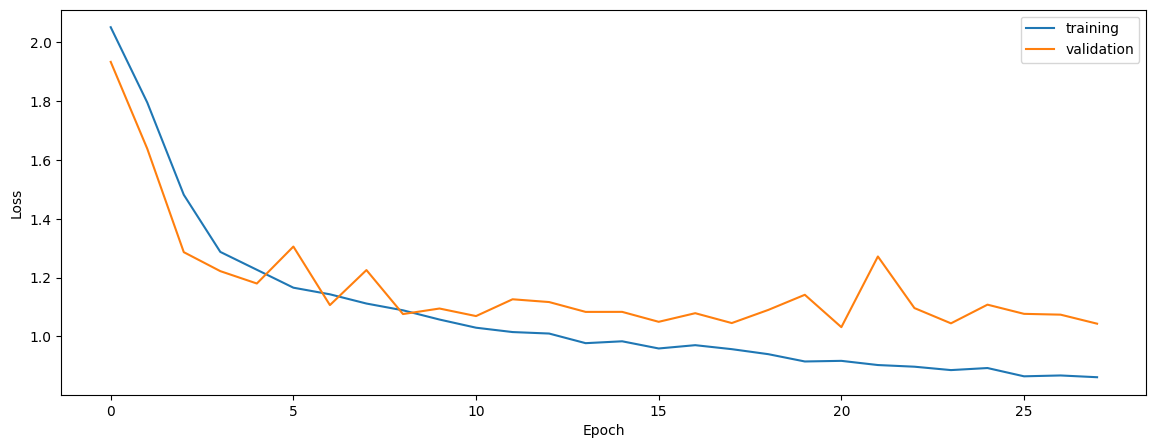

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_MSE_7_1_0_1_1_0_e_e_0_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_0_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1086687, 1656)
(1086687, 1)
validation
(145592, 1656)
(145592, 1)
test
(152076, 1656)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 1656)]            0         


 dense_6 (Dense)             (None, 2048)              3393536   


 dense_7 (Dense)             (None, 1024)              2098176   


 dense_8 (Dense)             (None, 512)               524800    


 dense_9 (Dense)             (None, 256)               131328    


 dense_10 (Dense)            (None, 128)               32896     


 dense_11 (Dense)            (None, 1)                 129       


Total params: 6180865 (23.58 MB)


Trainable params: 6180865 (23.58 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/11 [=>............................] - ETA: 1:57 - loss: 0.2199 - STD: 1.1030e-04 - MAE: 0.4328

 2/11 [====>.........................] - ETA: 17s - loss: 0.2375 - STD: 1.5602e-04 - MAE: 0.4604 

 3/11 [=======>......................] - ETA: 10s - loss: 0.2315 - STD: 2.1890e-04 - MAE: 0.4593

 4/11 [=========>....................] - ETA: 7s - loss: 0.2293 - STD: 2.6927e-04 - MAE: 0.4513 

 5/11 [============>.................] - ETA: 5s - loss: 0.2301 - STD: 3.0623e-04 - MAE: 0.4457

 6/11 [===============>..............] - ETA: 4s - loss: 0.2298 - STD: 3.4076e-04 - MAE: 0.4421

 7/11 [==================>...........] - ETA: 3s - loss: 0.2285 - STD: 3.7254e-04 - MAE: 0.4407

 8/11 [====================>.........] - ETA: 2s - loss: 0.2270 - STD: 3.9748e-04 - MAE: 0.4411

 9/11 [=======================>......] - ETA: 1s - loss: 0.2262 - STD: 4.1443e-04 - MAE: 0.4427

10/11 [==========================>...] - ETA: 0s - loss: 0.2259 - STD: 4.2540e-04 - MAE: 0.4446

11/11 [==============================] - ETA: 0s - loss: 0.2256 - STD: 4.3283e-04 - MAE: 0.4462

11/11 [==============================] - 26s 1s/step - loss: 0.2256 - STD: 4.3283e-04 - MAE: 0.4462 - val_loss: 0.2241 - val_STD: 5.3871e-04 - val_MAE: 0.4632


Epoch 2/10000


 1/11 [=>............................] - ETA: 15s - loss: 0.2203 - STD: 4.9651e-04 - MAE: 0.4570

 2/11 [====>.........................] - ETA: 5s - loss: 0.2191 - STD: 4.9092e-04 - MAE: 0.4535 

 3/11 [=======>......................] - ETA: 5s - loss: 0.2184 - STD: 4.8472e-04 - MAE: 0.4496

 4/11 [=========>....................] - ETA: 5s - loss: 0.2183 - STD: 4.7836e-04 - MAE: 0.4462

 5/11 [============>.................] - ETA: 5s - loss: 0.2187 - STD: 4.7362e-04 - MAE: 0.4437

 6/11 [===============>..............] - ETA: 4s - loss: 0.2190 - STD: 4.7196e-04 - MAE: 0.4418

 7/11 [==================>...........] - ETA: 3s - loss: 0.2189 - STD: 4.7380e-04 - MAE: 0.4406

 8/11 [====================>.........] - ETA: 2s - loss: 0.2189 - STD: 4.7877e-04 - MAE: 0.4402

 9/11 [=======================>......] - ETA: 1s - loss: 0.2187 - STD: 4.8631e-04 - MAE: 0.4403

10/11 [==========================>...] - ETA: 0s - loss: 0.2185 - STD: 4.9625e-04 - MAE: 0.4410

11/11 [==============================] - ETA: 0s - loss: 0.2185 - STD: 5.0785e-04 - MAE: 0.4418

11/11 [==============================] - 11s 972ms/step - loss: 0.2185 - STD: 5.0785e-04 - MAE: 0.4418 - val_loss: 0.2223 - val_STD: 7.1381e-04 - val_MAE: 0.4591


Epoch 3/10000


 1/11 [=>............................] - ETA: 14s - loss: 0.2181 - STD: 6.5966e-04 - MAE: 0.4521

 2/11 [====>.........................] - ETA: 5s - loss: 0.2183 - STD: 6.7994e-04 - MAE: 0.4524 

 3/11 [=======>......................] - ETA: 7s - loss: 0.2181 - STD: 7.0083e-04 - MAE: 0.4518

 4/11 [=========>....................] - ETA: 5s - loss: 0.2180 - STD: 7.2243e-04 - MAE: 0.4508

 5/11 [============>.................] - ETA: 5s - loss: 0.2178 - STD: 7.4635e-04 - MAE: 0.4495

 6/11 [===============>..............] - ETA: 4s - loss: 0.2177 - STD: 7.7113e-04 - MAE: 0.4480

 7/11 [==================>...........] - ETA: 3s - loss: 0.2177 - STD: 7.9934e-04 - MAE: 0.4467

 8/11 [====================>.........] - ETA: 2s - loss: 0.2177 - STD: 8.3033e-04 - MAE: 0.4455

 9/11 [=======================>......] - ETA: 1s - loss: 0.2178 - STD: 8.6613e-04 - MAE: 0.4447

10/11 [==========================>...] - ETA: 0s - loss: 0.2177 - STD: 9.0677e-04 - MAE: 0.4443

11/11 [==============================] - ETA: 0s - loss: 0.2177 - STD: 9.5205e-04 - MAE: 0.4442

11/11 [==============================] - 12s 1s/step - loss: 0.2177 - STD: 9.5205e-04 - MAE: 0.4442 - val_loss: 0.2206 - val_STD: 0.0017 - val_MAE: 0.4517


Epoch 4/10000


 1/11 [=>............................] - ETA: 16s - loss: 0.2172 - STD: 0.0016 - MAE: 0.4452

 2/11 [====>.........................] - ETA: 10s - loss: 0.2170 - STD: 0.0017 - MAE: 0.4460

 3/11 [=======>......................] - ETA: 9s - loss: 0.2173 - STD: 0.0017 - MAE: 0.4471 

 4/11 [=========>....................] - ETA: 7s - loss: 0.2173 - STD: 0.0019 - MAE: 0.4476

 5/11 [============>.................] - ETA: 5s - loss: 0.2173 - STD: 0.0020 - MAE: 0.4476

 6/11 [===============>..............] - ETA: 4s - loss: 0.2172 - STD: 0.0021 - MAE: 0.4473

 7/11 [==================>...........] - ETA: 3s - loss: 0.2171 - STD: 0.0022 - MAE: 0.4468

 8/11 [====================>.........] - ETA: 2s - loss: 0.2169 - STD: 0.0024 - MAE: 0.4460

 9/11 [=======================>......] - ETA: 1s - loss: 0.2169 - STD: 0.0026 - MAE: 0.4453

10/11 [==========================>...] - ETA: 0s - loss: 0.2169 - STD: 0.0028 - MAE: 0.4446

11/11 [==============================] - ETA: 0s - loss: 0.2168 - STD: 0.0030 - MAE: 0.4441

11/11 [==============================] - 12s 1s/step - loss: 0.2168 - STD: 0.0030 - MAE: 0.4441 - val_loss: 0.2194 - val_STD: 0.0066 - val_MAE: 0.4469


Epoch 5/10000


 1/11 [=>............................] - ETA: 11s - loss: 0.2161 - STD: 0.0061 - MAE: 0.4404

 2/11 [====>.........................] - ETA: 5s - loss: 0.2159 - STD: 0.0066 - MAE: 0.4411 

 3/11 [=======>......................] - ETA: 6s - loss: 0.2157 - STD: 0.0072 - MAE: 0.4417

 4/11 [=========>....................] - ETA: 6s - loss: 0.2155 - STD: 0.0079 - MAE: 0.4422

 5/11 [============>.................] - ETA: 5s - loss: 0.2153 - STD: 0.0087 - MAE: 0.4425

 6/11 [===============>..............] - ETA: 4s - loss: 0.2151 - STD: 0.0095 - MAE: 0.4424

 7/11 [==================>...........] - ETA: 3s - loss: 0.2148 - STD: 0.0105 - MAE: 0.4420

 8/11 [====================>.........] - ETA: 2s - loss: 0.2145 - STD: 0.0115 - MAE: 0.4413

 9/11 [=======================>......] - ETA: 1s - loss: 0.2143 - STD: 0.0127 - MAE: 0.4406

10/11 [==========================>...] - ETA: 0s - loss: 0.2139 - STD: 0.0141 - MAE: 0.4398

11/11 [==============================] - ETA: 0s - loss: 0.2136 - STD: 0.0158 - MAE: 0.4392

11/11 [==============================] - 11s 949ms/step - loss: 0.2136 - STD: 0.0158 - MAE: 0.4392 - val_loss: 0.2110 - val_STD: 0.0434 - val_MAE: 0.4383


Epoch 6/10000


 1/11 [=>............................] - ETA: 17s - loss: 0.2092 - STD: 0.0408 - MAE: 0.4330

 2/11 [====>.........................] - ETA: 6s - loss: 0.2082 - STD: 0.0447 - MAE: 0.4317 

 3/11 [=======>......................] - ETA: 6s - loss: 0.2073 - STD: 0.0482 - MAE: 0.4300

 4/11 [=========>....................] - ETA: 5s - loss: 0.2065 - STD: 0.0514 - MAE: 0.4281

 5/11 [============>.................] - ETA: 5s - loss: 0.2059 - STD: 0.0547 - MAE: 0.4263

 6/11 [===============>..............] - ETA: 4s - loss: 0.2049 - STD: 0.0585 - MAE: 0.4244

 7/11 [==================>...........] - ETA: 3s - loss: 0.2041 - STD: 0.0631 - MAE: 0.4229

 8/11 [====================>.........] - ETA: 2s - loss: 0.2034 - STD: 0.0678 - MAE: 0.4214

 9/11 [=======================>......] - ETA: 1s - loss: 0.2027 - STD: 0.0721 - MAE: 0.4199

10/11 [==========================>...] - ETA: 0s - loss: 0.2021 - STD: 0.0758 - MAE: 0.4184

11/11 [==============================] - ETA: 0s - loss: 0.2015 - STD: 0.0797 - MAE: 0.4170

11/11 [==============================] - 12s 1s/step - loss: 0.2015 - STD: 0.0797 - MAE: 0.4170 - val_loss: 0.1995 - val_STD: 0.1409 - val_MAE: 0.4082


Epoch 7/10000


 1/11 [=>............................] - ETA: 11s - loss: 0.1950 - STD: 0.1280 - MAE: 0.4013

 2/11 [====>.........................] - ETA: 8s - loss: 0.1942 - STD: 0.1304 - MAE: 0.4000 

 3/11 [=======>......................] - ETA: 6s - loss: 0.1941 - STD: 0.1312 - MAE: 0.3997

 4/11 [=========>....................] - ETA: 5s - loss: 0.1938 - STD: 0.1327 - MAE: 0.3992

 5/11 [============>.................] - ETA: 4s - loss: 0.1934 - STD: 0.1344 - MAE: 0.3984

 6/11 [===============>..............] - ETA: 4s - loss: 0.1930 - STD: 0.1359 - MAE: 0.3976

 7/11 [==================>...........] - ETA: 3s - loss: 0.1927 - STD: 0.1372 - MAE: 0.3969

 8/11 [====================>.........] - ETA: 2s - loss: 0.1925 - STD: 0.1390 - MAE: 0.3961

 9/11 [=======================>......] - ETA: 1s - loss: 0.1924 - STD: 0.1411 - MAE: 0.3954

10/11 [==========================>...] - ETA: 0s - loss: 0.1921 - STD: 0.1424 - MAE: 0.3947

11/11 [==============================] - ETA: 0s - loss: 0.1919 - STD: 0.1436 - MAE: 0.3942

11/11 [==============================] - 12s 1s/step - loss: 0.1919 - STD: 0.1436 - MAE: 0.3942 - val_loss: 0.1957 - val_STD: 0.1783 - val_MAE: 0.3935


Epoch 8/10000


 1/11 [=>............................] - ETA: 16s - loss: 0.1894 - STD: 0.1597 - MAE: 0.3879

 2/11 [====>.........................] - ETA: 10s - loss: 0.1890 - STD: 0.1572 - MAE: 0.3877

 3/11 [=======>......................] - ETA: 7s - loss: 0.1891 - STD: 0.1581 - MAE: 0.3874 

 4/11 [=========>....................] - ETA: 6s - loss: 0.1891 - STD: 0.1585 - MAE: 0.3874

 5/11 [============>.................] - ETA: 5s - loss: 0.1889 - STD: 0.1582 - MAE: 0.3872

 6/11 [===============>..............] - ETA: 4s - loss: 0.1887 - STD: 0.1589 - MAE: 0.3869

 7/11 [==================>...........] - ETA: 3s - loss: 0.1885 - STD: 0.1584 - MAE: 0.3866

 8/11 [====================>.........] - ETA: 2s - loss: 0.1884 - STD: 0.1604 - MAE: 0.3862

 9/11 [=======================>......] - ETA: 1s - loss: 0.1885 - STD: 0.1583 - MAE: 0.3861

10/11 [==========================>...] - ETA: 0s - loss: 0.1884 - STD: 0.1599 - MAE: 0.3859

11/11 [==============================] - ETA: 0s - loss: 0.1883 - STD: 0.1608 - MAE: 0.3856

11/11 [==============================] - 12s 996ms/step - loss: 0.1883 - STD: 0.1608 - MAE: 0.3856 - val_loss: 0.1880 - val_STD: 0.1692 - val_MAE: 0.3838


Epoch 9/10000


 1/11 [=>............................] - ETA: 16s - loss: 0.1875 - STD: 0.1451 - MAE: 0.3840

 2/11 [====>.........................] - ETA: 8s - loss: 0.1868 - STD: 0.1547 - MAE: 0.3838 

 3/11 [=======>......................] - ETA: 7s - loss: 0.1868 - STD: 0.1615 - MAE: 0.3838

 4/11 [=========>....................] - ETA: 6s - loss: 0.1866 - STD: 0.1599 - MAE: 0.3830

 5/11 [============>.................] - ETA: 4s - loss: 0.1862 - STD: 0.1610 - MAE: 0.3822

 6/11 [===============>..............] - ETA: 4s - loss: 0.1863 - STD: 0.1643 - MAE: 0.3822

 7/11 [==================>...........] - ETA: 3s - loss: 0.1860 - STD: 0.1642 - MAE: 0.3817

 8/11 [====================>.........] - ETA: 2s - loss: 0.1856 - STD: 0.1640 - MAE: 0.3811

 9/11 [=======================>......] - ETA: 1s - loss: 0.1855 - STD: 0.1651 - MAE: 0.3812

10/11 [==========================>...] - ETA: 0s - loss: 0.1851 - STD: 0.1653 - MAE: 0.3807

11/11 [==============================] - ETA: 0s - loss: 0.1846 - STD: 0.1656 - MAE: 0.3800

11/11 [==============================] - 12s 994ms/step - loss: 0.1846 - STD: 0.1656 - MAE: 0.3800 - val_loss: 0.1833 - val_STD: 0.1997 - val_MAE: 0.3769


Epoch 10/10000


 1/11 [=>............................] - ETA: 17s - loss: 0.1824 - STD: 0.1801 - MAE: 0.3791

 2/11 [====>.........................] - ETA: 9s - loss: 0.1811 - STD: 0.1757 - MAE: 0.3737 

 3/11 [=======>......................] - ETA: 8s - loss: 0.1798 - STD: 0.1777 - MAE: 0.3729

 4/11 [=========>....................] - ETA: 7s - loss: 0.1786 - STD: 0.1793 - MAE: 0.3718

 5/11 [============>.................] - ETA: 5s - loss: 0.1789 - STD: 0.1783 - MAE: 0.3701

 6/11 [===============>..............] - ETA: 4s - loss: 0.1824 - STD: 0.1808 - MAE: 0.3739

 7/11 [==================>...........] - ETA: 4s - loss: 0.1862 - STD: 0.1745 - MAE: 0.3737

 8/11 [====================>.........] - ETA: 3s - loss: 0.1889 - STD: 0.1703 - MAE: 0.3734

 9/11 [=======================>......] - ETA: 2s - loss: 0.1871 - STD: 0.1736 - MAE: 0.3720

10/11 [==========================>...] - ETA: 1s - loss: 0.1900 - STD: 0.1760 - MAE: 0.3750

11/11 [==============================] - ETA: 0s - loss: 0.1886 - STD: 0.1776 - MAE: 0.3740

11/11 [==============================] - 14s 1s/step - loss: 0.1886 - STD: 0.1776 - MAE: 0.3740 - val_loss: 0.1841 - val_STD: 0.1842 - val_MAE: 0.3627


Epoch 11/10000


 1/11 [=>............................] - ETA: 18s - loss: 0.1912 - STD: 0.1550 - MAE: 0.3700

 2/11 [====>.........................] - ETA: 9s - loss: 0.1936 - STD: 0.1495 - MAE: 0.3726 

 3/11 [=======>......................] - ETA: 8s - loss: 0.1900 - STD: 0.1527 - MAE: 0.3725

 4/11 [=========>....................] - ETA: 7s - loss: 0.1872 - STD: 0.1582 - MAE: 0.3738

 5/11 [============>.................] - ETA: 6s - loss: 0.1881 - STD: 0.1620 - MAE: 0.3775

 6/11 [===============>..............] - ETA: 5s - loss: 0.1878 - STD: 0.1648 - MAE: 0.3790

 7/11 [==================>...........] - ETA: 4s - loss: 0.1865 - STD: 0.1655 - MAE: 0.3786

 8/11 [====================>.........] - ETA: 3s - loss: 0.1861 - STD: 0.1649 - MAE: 0.3779

 9/11 [=======================>......] - ETA: 2s - loss: 0.1862 - STD: 0.1639 - MAE: 0.3774

10/11 [==========================>...] - ETA: 1s - loss: 0.1859 - STD: 0.1642 - MAE: 0.3765

11/11 [==============================] - ETA: 0s - loss: 0.1852 - STD: 0.1657 - MAE: 0.3758

11/11 [==============================] - 14s 1s/step - loss: 0.1852 - STD: 0.1657 - MAE: 0.3758 - val_loss: 0.1841 - val_STD: 0.2066 - val_MAE: 0.3753


Epoch 12/10000


 1/11 [=>............................] - ETA: 16s - loss: 0.1810 - STD: 0.1903 - MAE: 0.3745

 2/11 [====>.........................] - ETA: 9s - loss: 0.1817 - STD: 0.1909 - MAE: 0.3757 

 3/11 [=======>......................] - ETA: 8s - loss: 0.1807 - STD: 0.1898 - MAE: 0.3745

 4/11 [=========>....................] - ETA: 7s - loss: 0.1796 - STD: 0.1871 - MAE: 0.3727

 5/11 [============>.................] - ETA: 6s - loss: 0.1795 - STD: 0.1837 - MAE: 0.3714

 6/11 [===============>..............] - ETA: 5s - loss: 0.1792 - STD: 0.1810 - MAE: 0.3706

 7/11 [==================>...........] - ETA: 4s - loss: 0.1786 - STD: 0.1798 - MAE: 0.3704

 8/11 [====================>.........] - ETA: 3s - loss: 0.1783 - STD: 0.1794 - MAE: 0.3709

 9/11 [=======================>......] - ETA: 1s - loss: 0.1782 - STD: 0.1794 - MAE: 0.3715

10/11 [==========================>...] - ETA: 0s - loss: 0.1776 - STD: 0.1794 - MAE: 0.3710

11/11 [==============================] - ETA: 0s - loss: 0.1773 - STD: 0.1792 - MAE: 0.3702

11/11 [==============================] - 13s 1s/step - loss: 0.1773 - STD: 0.1792 - MAE: 0.3702 - val_loss: 0.1718 - val_STD: 0.2059 - val_MAE: 0.3561


Epoch 13/10000


 1/11 [=>............................] - ETA: 12s - loss: 0.1734 - STD: 0.1838 - MAE: 0.3579

 2/11 [====>.........................] - ETA: 9s - loss: 0.1721 - STD: 0.1889 - MAE: 0.3586 

 3/11 [=======>......................] - ETA: 7s - loss: 0.1726 - STD: 0.1936 - MAE: 0.3603

 4/11 [=========>....................] - ETA: 7s - loss: 0.1722 - STD: 0.1969 - MAE: 0.3595

 5/11 [============>.................] - ETA: 5s - loss: 0.1720 - STD: 0.1984 - MAE: 0.3577

 6/11 [===============>..............] - ETA: 4s - loss: 0.1719 - STD: 0.1999 - MAE: 0.3562

 7/11 [==================>...........] - ETA: 4s - loss: 0.1717 - STD: 0.2026 - MAE: 0.3555

 8/11 [====================>.........] - ETA: 2s - loss: 0.1717 - STD: 0.2051 - MAE: 0.3554

 9/11 [=======================>......] - ETA: 1s - loss: 0.1715 - STD: 0.2062 - MAE: 0.3544

10/11 [==========================>...] - ETA: 0s - loss: 0.1715 - STD: 0.2069 - MAE: 0.3536

11/11 [==============================] - ETA: 0s - loss: 0.1712 - STD: 0.2082 - MAE: 0.3530

11/11 [==============================] - 12s 1s/step - loss: 0.1712 - STD: 0.2082 - MAE: 0.3530 - val_loss: 0.1755 - val_STD: 0.2443 - val_MAE: 0.3532


Epoch 14/10000


 1/11 [=>............................] - ETA: 11s - loss: 0.1711 - STD: 0.2258 - MAE: 0.3515

 2/11 [====>.........................] - ETA: 12s - loss: 0.1698 - STD: 0.2218 - MAE: 0.3490

 3/11 [=======>......................] - ETA: 8s - loss: 0.1700 - STD: 0.2187 - MAE: 0.3483 

 4/11 [=========>....................] - ETA: 6s - loss: 0.1696 - STD: 0.2186 - MAE: 0.3484

 5/11 [============>.................] - ETA: 5s - loss: 0.1697 - STD: 0.2191 - MAE: 0.3489

 6/11 [===============>..............] - ETA: 4s - loss: 0.1694 - STD: 0.2186 - MAE: 0.3486

 7/11 [==================>...........] - ETA: 3s - loss: 0.1693 - STD: 0.2176 - MAE: 0.3485

 8/11 [====================>.........] - ETA: 2s - loss: 0.1693 - STD: 0.2172 - MAE: 0.3486

 9/11 [=======================>......] - ETA: 1s - loss: 0.1692 - STD: 0.2172 - MAE: 0.3488

10/11 [==========================>...] - ETA: 0s - loss: 0.1690 - STD: 0.2169 - MAE: 0.3488

11/11 [==============================] - ETA: 0s - loss: 0.1689 - STD: 0.2162 - MAE: 0.3488

11/11 [==============================] - 10s 879ms/step - loss: 0.1689 - STD: 0.2162 - MAE: 0.3488 - val_loss: 0.1687 - val_STD: 0.2317 - val_MAE: 0.3481


Epoch 15/10000


 1/11 [=>............................] - ETA: 15s - loss: 0.1678 - STD: 0.2101 - MAE: 0.3490

 2/11 [====>.........................] - ETA: 9s - loss: 0.1686 - STD: 0.2119 - MAE: 0.3507 

 3/11 [=======>......................] - ETA: 8s - loss: 0.1686 - STD: 0.2116 - MAE: 0.3512

 4/11 [=========>....................] - ETA: 7s - loss: 0.1685 - STD: 0.2103 - MAE: 0.3508

 5/11 [============>.................] - ETA: 6s - loss: 0.1682 - STD: 0.2097 - MAE: 0.3504

 6/11 [===============>..............] - ETA: 4s - loss: 0.1682 - STD: 0.2102 - MAE: 0.3508

 7/11 [==================>...........] - ETA: 3s - loss: 0.1680 - STD: 0.2103 - MAE: 0.3508

 8/11 [====================>.........] - ETA: 2s - loss: 0.1680 - STD: 0.2098 - MAE: 0.3506

 9/11 [=======================>......] - ETA: 1s - loss: 0.1678 - STD: 0.2099 - MAE: 0.3503

10/11 [==========================>...] - ETA: 0s - loss: 0.1677 - STD: 0.2107 - MAE: 0.3501

11/11 [==============================] - ETA: 0s - loss: 0.1677 - STD: 0.2111 - MAE: 0.3499

11/11 [==============================] - 12s 1s/step - loss: 0.1677 - STD: 0.2111 - MAE: 0.3499 - val_loss: 0.1675 - val_STD: 0.2376 - val_MAE: 0.3439


Epoch 16/10000


 1/11 [=>............................] - ETA: 12s - loss: 0.1658 - STD: 0.2140 - MAE: 0.3447

 2/11 [====>.........................] - ETA: 8s - loss: 0.1667 - STD: 0.2163 - MAE: 0.3457 

 3/11 [=======>......................] - ETA: 8s - loss: 0.1669 - STD: 0.2191 - MAE: 0.3460

 4/11 [=========>....................] - ETA: 6s - loss: 0.1669 - STD: 0.2196 - MAE: 0.3455

 5/11 [============>.................] - ETA: 5s - loss: 0.1668 - STD: 0.2193 - MAE: 0.3451

 6/11 [===============>..............] - ETA: 4s - loss: 0.1668 - STD: 0.2199 - MAE: 0.3450

 7/11 [==================>...........] - ETA: 3s - loss: 0.1669 - STD: 0.2207 - MAE: 0.3452

 8/11 [====================>.........] - ETA: 2s - loss: 0.1670 - STD: 0.2203 - MAE: 0.3452

 9/11 [=======================>......] - ETA: 1s - loss: 0.1670 - STD: 0.2202 - MAE: 0.3451

10/11 [==========================>...] - ETA: 0s - loss: 0.1669 - STD: 0.2205 - MAE: 0.3451

11/11 [==============================] - ETA: 0s - loss: 0.1667 - STD: 0.2206 - MAE: 0.3451

11/11 [==============================] - 13s 1s/step - loss: 0.1667 - STD: 0.2206 - MAE: 0.3451 - val_loss: 0.1666 - val_STD: 0.2396 - val_MAE: 0.3417


Epoch 17/10000


 1/11 [=>............................] - ETA: 15s - loss: 0.1670 - STD: 0.2169 - MAE: 0.3443

 2/11 [====>.........................] - ETA: 10s - loss: 0.1665 - STD: 0.2188 - MAE: 0.3448

 3/11 [=======>......................] - ETA: 8s - loss: 0.1664 - STD: 0.2201 - MAE: 0.3451 

 4/11 [=========>....................] - ETA: 7s - loss: 0.1663 - STD: 0.2194 - MAE: 0.3448

 5/11 [============>.................] - ETA: 6s - loss: 0.1663 - STD: 0.2195 - MAE: 0.3449

 6/11 [===============>..............] - ETA: 5s - loss: 0.1663 - STD: 0.2198 - MAE: 0.3450

 7/11 [==================>...........] - ETA: 4s - loss: 0.1663 - STD: 0.2197 - MAE: 0.3449

 8/11 [====================>.........] - ETA: 2s - loss: 0.1660 - STD: 0.2197 - MAE: 0.3446

 9/11 [=======================>......] - ETA: 1s - loss: 0.1658 - STD: 0.2198 - MAE: 0.3446

10/11 [==========================>...] - ETA: 0s - loss: 0.1657 - STD: 0.2198 - MAE: 0.3445

11/11 [==============================] - ETA: 0s - loss: 0.1658 - STD: 0.2197 - MAE: 0.3445

11/11 [==============================] - 12s 1s/step - loss: 0.1658 - STD: 0.2197 - MAE: 0.3445 - val_loss: 0.1673 - val_STD: 0.2425 - val_MAE: 0.3434


Epoch 18/10000


 1/11 [=>............................] - ETA: 12s - loss: 0.1654 - STD: 0.2208 - MAE: 0.3447

 2/11 [====>.........................] - ETA: 5s - loss: 0.1644 - STD: 0.2207 - MAE: 0.3436 

 3/11 [=======>......................] - ETA: 5s - loss: 0.1647 - STD: 0.2205 - MAE: 0.3434

 4/11 [=========>....................] - ETA: 4s - loss: 0.1649 - STD: 0.2212 - MAE: 0.3435

 5/11 [============>.................] - ETA: 4s - loss: 0.1651 - STD: 0.2218 - MAE: 0.3437

 6/11 [===============>..............] - ETA: 4s - loss: 0.1650 - STD: 0.2216 - MAE: 0.3434

 7/11 [==================>...........] - ETA: 3s - loss: 0.1650 - STD: 0.2220 - MAE: 0.3432

 8/11 [====================>.........] - ETA: 2s - loss: 0.1650 - STD: 0.2225 - MAE: 0.3431

 9/11 [=======================>......] - ETA: 1s - loss: 0.1649 - STD: 0.2226 - MAE: 0.3429

10/11 [==========================>...] - ETA: 0s - loss: 0.1649 - STD: 0.2229 - MAE: 0.3427

11/11 [==============================] - ETA: 0s - loss: 0.1649 - STD: 0.2232 - MAE: 0.3426

11/11 [==============================] - 12s 1s/step - loss: 0.1649 - STD: 0.2232 - MAE: 0.3426 - val_loss: 0.1658 - val_STD: 0.2476 - val_MAE: 0.3389


Epoch 19/10000


 1/11 [=>............................] - ETA: 12s - loss: 0.1647 - STD: 0.2248 - MAE: 0.3411

 2/11 [====>.........................] - ETA: 7s - loss: 0.1648 - STD: 0.2252 - MAE: 0.3414 

 3/11 [=======>......................] - ETA: 6s - loss: 0.1644 - STD: 0.2254 - MAE: 0.3412

 4/11 [=========>....................] - ETA: 6s - loss: 0.1642 - STD: 0.2249 - MAE: 0.3410

 5/11 [============>.................] - ETA: 5s - loss: 0.1640 - STD: 0.2251 - MAE: 0.3408

 6/11 [===============>..............] - ETA: 4s - loss: 0.1640 - STD: 0.2252 - MAE: 0.3409

 7/11 [==================>...........] - ETA: 3s - loss: 0.1641 - STD: 0.2252 - MAE: 0.3408

 8/11 [====================>.........] - ETA: 3s - loss: 0.1640 - STD: 0.2254 - MAE: 0.3408

 9/11 [=======================>......] - ETA: 2s - loss: 0.1640 - STD: 0.2256 - MAE: 0.3408

10/11 [==========================>...] - ETA: 0s - loss: 0.1640 - STD: 0.2253 - MAE: 0.3408

11/11 [==============================] - ETA: 0s - loss: 0.1641 - STD: 0.2256 - MAE: 0.3408

11/11 [==============================] - 12s 1s/step - loss: 0.1641 - STD: 0.2256 - MAE: 0.3408 - val_loss: 0.1645 - val_STD: 0.2465 - val_MAE: 0.3376


Epoch 20/10000


 1/11 [=>............................] - ETA: 16s - loss: 0.1637 - STD: 0.2236 - MAE: 0.3402

 2/11 [====>.........................] - ETA: 5s - loss: 0.1634 - STD: 0.2237 - MAE: 0.3402 

 3/11 [=======>......................] - ETA: 7s - loss: 0.1635 - STD: 0.2250 - MAE: 0.3405

 4/11 [=========>....................] - ETA: 6s - loss: 0.1636 - STD: 0.2244 - MAE: 0.3405

 5/11 [============>.................] - ETA: 4s - loss: 0.1635 - STD: 0.2248 - MAE: 0.3404

 6/11 [===============>..............] - ETA: 4s - loss: 0.1634 - STD: 0.2251 - MAE: 0.3402

 7/11 [==================>...........] - ETA: 3s - loss: 0.1633 - STD: 0.2258 - MAE: 0.3400

 8/11 [====================>.........] - ETA: 2s - loss: 0.1632 - STD: 0.2260 - MAE: 0.3398

 9/11 [=======================>......] - ETA: 1s - loss: 0.1632 - STD: 0.2265 - MAE: 0.3396

10/11 [==========================>...] - ETA: 0s - loss: 0.1632 - STD: 0.2269 - MAE: 0.3395

11/11 [==============================] - ETA: 0s - loss: 0.1632 - STD: 0.2271 - MAE: 0.3394

11/11 [==============================] - 12s 1s/step - loss: 0.1632 - STD: 0.2271 - MAE: 0.3394 - val_loss: 0.1642 - val_STD: 0.2523 - val_MAE: 0.3355


Epoch 21/10000


 1/11 [=>............................] - ETA: 12s - loss: 0.1623 - STD: 0.2303 - MAE: 0.3373

 2/11 [====>.........................] - ETA: 8s - loss: 0.1623 - STD: 0.2290 - MAE: 0.3375 

 3/11 [=======>......................] - ETA: 8s - loss: 0.1624 - STD: 0.2295 - MAE: 0.3378

 4/11 [=========>....................] - ETA: 6s - loss: 0.1624 - STD: 0.2287 - MAE: 0.3378

 5/11 [============>.................] - ETA: 6s - loss: 0.1625 - STD: 0.2289 - MAE: 0.3381

 6/11 [===============>..............] - ETA: 4s - loss: 0.1625 - STD: 0.2287 - MAE: 0.3381

 7/11 [==================>...........] - ETA: 3s - loss: 0.1625 - STD: 0.2289 - MAE: 0.3382

 8/11 [====================>.........] - ETA: 2s - loss: 0.1625 - STD: 0.2286 - MAE: 0.3381

 9/11 [=======================>......] - ETA: 1s - loss: 0.1626 - STD: 0.2294 - MAE: 0.3383

10/11 [==========================>...] - ETA: 0s - loss: 0.1632 - STD: 0.2277 - MAE: 0.3383

11/11 [==============================] - ETA: 0s - loss: 0.1638 - STD: 0.2289 - MAE: 0.3391

11/11 [==============================] - 12s 1s/step - loss: 0.1638 - STD: 0.2289 - MAE: 0.3391 - val_loss: 0.1692 - val_STD: 0.2294 - val_MAE: 0.3342


Epoch 22/10000


 1/11 [=>............................] - ETA: 16s - loss: 0.1760 - STD: 0.1994 - MAE: 0.3427

 2/11 [====>.........................] - ETA: 10s - loss: 0.1689 - STD: 0.2152 - MAE: 0.3400

 3/11 [=======>......................] - ETA: 7s - loss: 0.1701 - STD: 0.2227 - MAE: 0.3435 

 4/11 [=========>....................] - ETA: 5s - loss: 0.1729 - STD: 0.2144 - MAE: 0.3444

 5/11 [============>.................] - ETA: 5s - loss: 0.1719 - STD: 0.2127 - MAE: 0.3439

 6/11 [===============>..............] - ETA: 4s - loss: 0.1745 - STD: 0.2151 - MAE: 0.3480

 7/11 [==================>...........] - ETA: 3s - loss: 0.1732 - STD: 0.2137 - MAE: 0.3476

 8/11 [====================>.........] - ETA: 2s - loss: 0.1737 - STD: 0.2101 - MAE: 0.3481

 9/11 [=======================>......] - ETA: 1s - loss: 0.1727 - STD: 0.2094 - MAE: 0.3481

10/11 [==========================>...] - ETA: 0s - loss: 0.1731 - STD: 0.2099 - MAE: 0.3496

11/11 [==============================] - ETA: 0s - loss: 0.1724 - STD: 0.2095 - MAE: 0.3498

11/11 [==============================] - 12s 1s/step - loss: 0.1724 - STD: 0.2095 - MAE: 0.3498 - val_loss: 0.1692 - val_STD: 0.2136 - val_MAE: 0.3476


Epoch 23/10000


 1/11 [=>............................] - ETA: 15s - loss: 0.1706 - STD: 0.1863 - MAE: 0.3510

 2/11 [====>.........................] - ETA: 8s - loss: 0.1688 - STD: 0.1900 - MAE: 0.3497 

 3/11 [=======>......................] - ETA: 7s - loss: 0.1681 - STD: 0.1977 - MAE: 0.3506

 4/11 [=========>....................] - ETA: 6s - loss: 0.1682 - STD: 0.2027 - MAE: 0.3514

 5/11 [============>.................] - ETA: 5s - loss: 0.1677 - STD: 0.2030 - MAE: 0.3502

 6/11 [===============>..............] - ETA: 4s - loss: 0.1678 - STD: 0.2026 - MAE: 0.3495

 7/11 [==================>...........] - ETA: 3s - loss: 0.1671 - STD: 0.2050 - MAE: 0.3487

 8/11 [====================>.........] - ETA: 2s - loss: 0.1672 - STD: 0.2082 - MAE: 0.3486

 9/11 [=======================>......] - ETA: 1s - loss: 0.1666 - STD: 0.2095 - MAE: 0.3474

10/11 [==========================>...] - ETA: 0s - loss: 0.1667 - STD: 0.2097 - MAE: 0.3467

11/11 [==============================] - ETA: 0s - loss: 0.1663 - STD: 0.2117 - MAE: 0.3459

11/11 [==============================] - 13s 1s/step - loss: 0.1663 - STD: 0.2117 - MAE: 0.3459 - val_loss: 0.1716 - val_STD: 0.2573 - val_MAE: 0.3428


Epoch 24/10000


 1/11 [=>............................] - ETA: 17s - loss: 0.1660 - STD: 0.2395 - MAE: 0.3424

 2/11 [====>.........................] - ETA: 7s - loss: 0.1645 - STD: 0.2315 - MAE: 0.3388 

 3/11 [=======>......................] - ETA: 7s - loss: 0.1646 - STD: 0.2285 - MAE: 0.3378

 4/11 [=========>....................] - ETA: 6s - loss: 0.1642 - STD: 0.2315 - MAE: 0.3378

 5/11 [============>.................] - ETA: 6s - loss: 0.1641 - STD: 0.2331 - MAE: 0.3378

 6/11 [===============>..............] - ETA: 5s - loss: 0.1641 - STD: 0.2317 - MAE: 0.3372

 7/11 [==================>...........] - ETA: 4s - loss: 0.1636 - STD: 0.2318 - MAE: 0.3366

 8/11 [====================>.........] - ETA: 3s - loss: 0.1637 - STD: 0.2330 - MAE: 0.3370

 9/11 [=======================>......] - ETA: 2s - loss: 0.1636 - STD: 0.2329 - MAE: 0.3369

10/11 [==========================>...] - ETA: 0s - loss: 0.1637 - STD: 0.2321 - MAE: 0.3368

11/11 [==============================] - ETA: 0s - loss: 0.1634 - STD: 0.2321 - MAE: 0.3367

11/11 [==============================] - 13s 1s/step - loss: 0.1634 - STD: 0.2321 - MAE: 0.3367 - val_loss: 0.1666 - val_STD: 0.2540 - val_MAE: 0.3388


Epoch 25/10000


 1/11 [=>............................] - ETA: 13s - loss: 0.1627 - STD: 0.2346 - MAE: 0.3394

 2/11 [====>.........................] - ETA: 10s - loss: 0.1619 - STD: 0.2296 - MAE: 0.3378

 3/11 [=======>......................] - ETA: 6s - loss: 0.1622 - STD: 0.2272 - MAE: 0.3377 

 4/11 [=========>....................] - ETA: 6s - loss: 0.1619 - STD: 0.2280 - MAE: 0.3377

 5/11 [============>.................] - ETA: 5s - loss: 0.1621 - STD: 0.2284 - MAE: 0.3383

 6/11 [===============>..............] - ETA: 4s - loss: 0.1620 - STD: 0.2273 - MAE: 0.3381

 7/11 [==================>...........] - ETA: 3s - loss: 0.1620 - STD: 0.2264 - MAE: 0.3381

 8/11 [====================>.........] - ETA: 2s - loss: 0.1621 - STD: 0.2268 - MAE: 0.3385

 9/11 [=======================>......] - ETA: 1s - loss: 0.1620 - STD: 0.2270 - MAE: 0.3386

10/11 [==========================>...] - ETA: 0s - loss: 0.1620 - STD: 0.2265 - MAE: 0.3385

11/11 [==============================] - ETA: 0s - loss: 0.1619 - STD: 0.2264 - MAE: 0.3383

11/11 [==============================] - 11s 1s/step - loss: 0.1619 - STD: 0.2264 - MAE: 0.3383 - val_loss: 0.1640 - val_STD: 0.2531 - val_MAE: 0.3360


Epoch 26/10000


 1/11 [=>............................] - ETA: 16s - loss: 0.1615 - STD: 0.2323 - MAE: 0.3379

 2/11 [====>.........................] - ETA: 8s - loss: 0.1610 - STD: 0.2315 - MAE: 0.3366 

 3/11 [=======>......................] - ETA: 6s - loss: 0.1608 - STD: 0.2308 - MAE: 0.3356

 4/11 [=========>....................] - ETA: 6s - loss: 0.1611 - STD: 0.2316 - MAE: 0.3357

 5/11 [============>.................] - ETA: 5s - loss: 0.1610 - STD: 0.2326 - MAE: 0.3355

 6/11 [===============>..............] - ETA: 4s - loss: 0.1609 - STD: 0.2326 - MAE: 0.3351

 7/11 [==================>...........] - ETA: 3s - loss: 0.1608 - STD: 0.2329 - MAE: 0.3347

 8/11 [====================>.........] - ETA: 2s - loss: 0.1607 - STD: 0.2336 - MAE: 0.3346

 9/11 [=======================>......] - ETA: 1s - loss: 0.1609 - STD: 0.2338 - MAE: 0.3346

10/11 [==========================>...] - ETA: 0s - loss: 0.1610 - STD: 0.2338 - MAE: 0.3346

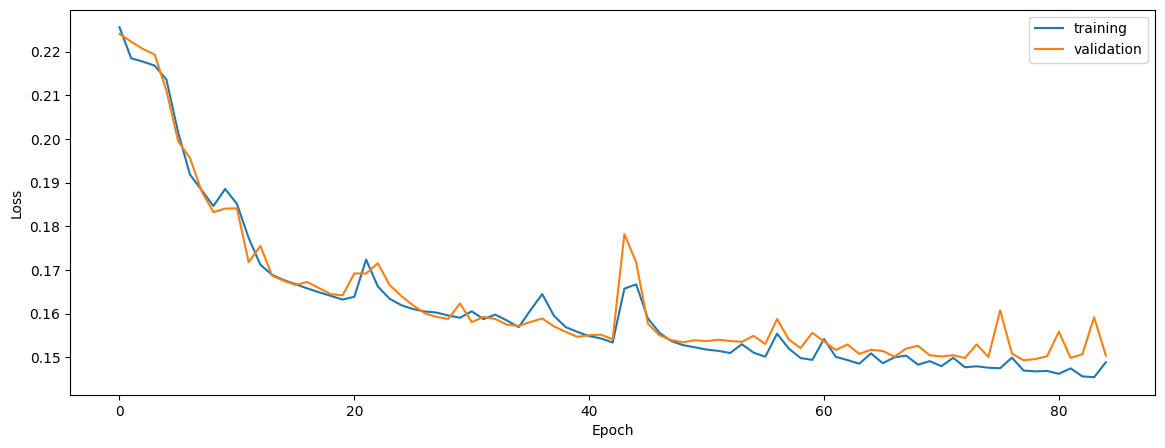

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

0.6686341069505922
0.6804818247255714
0.646175995811701


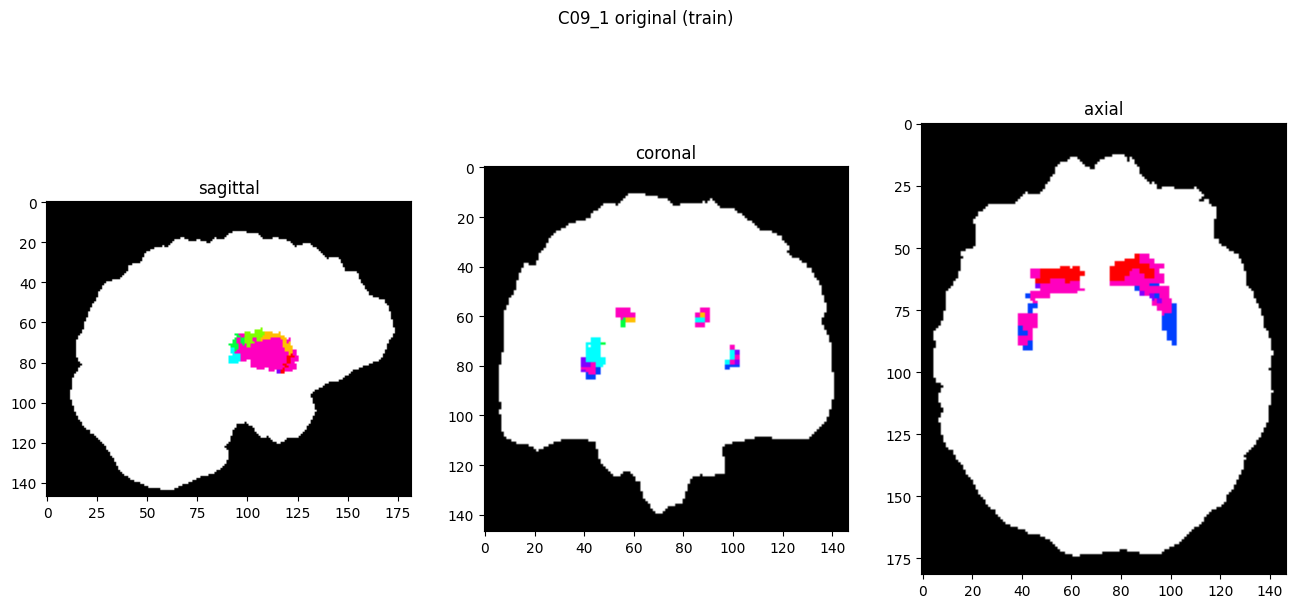

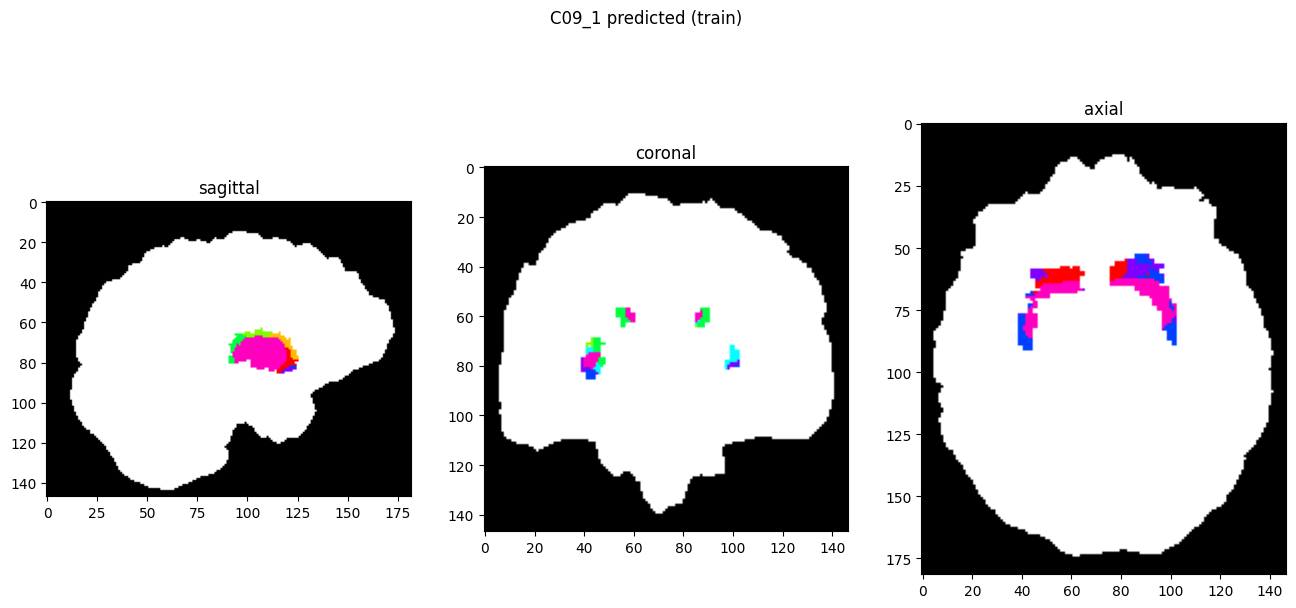

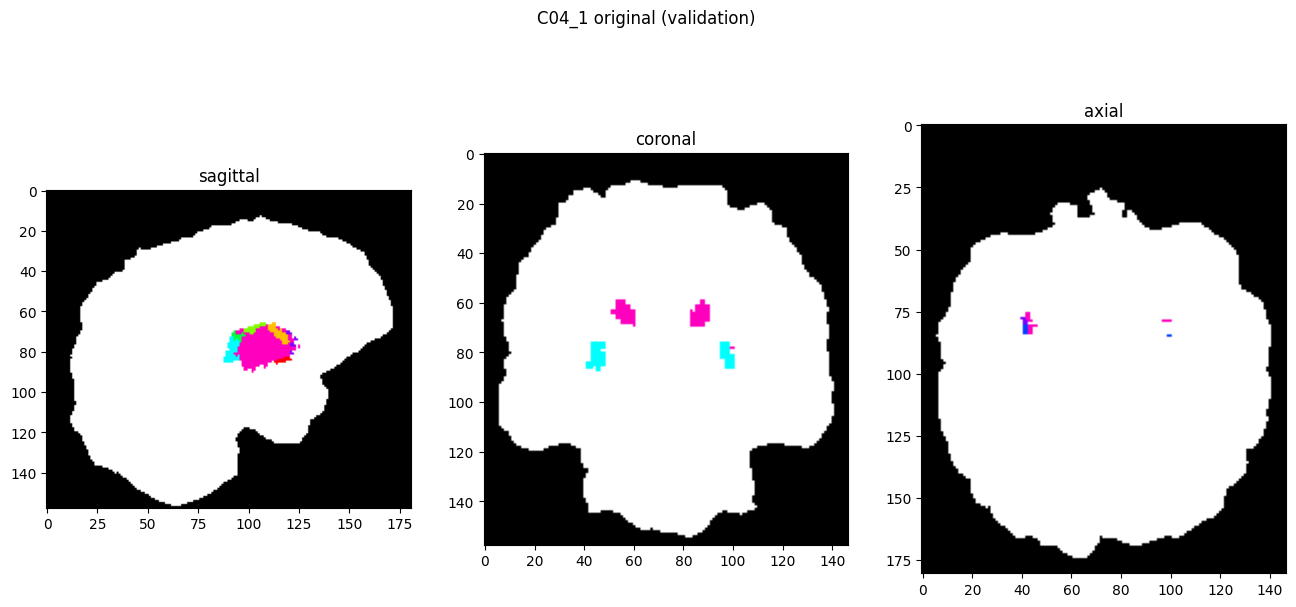

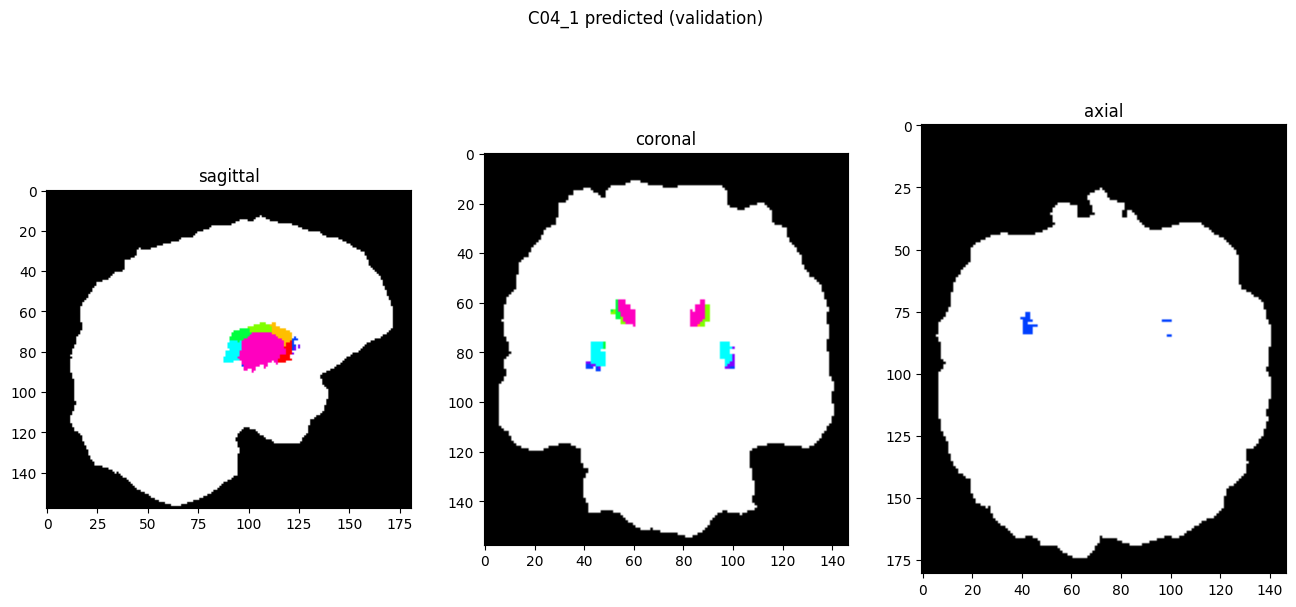

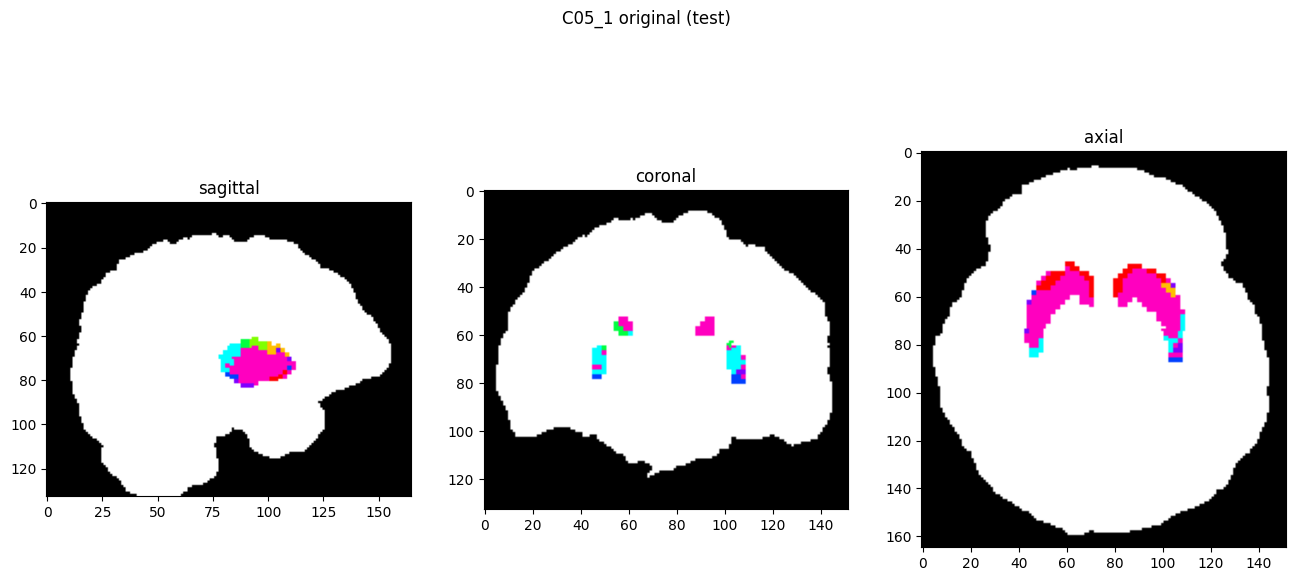

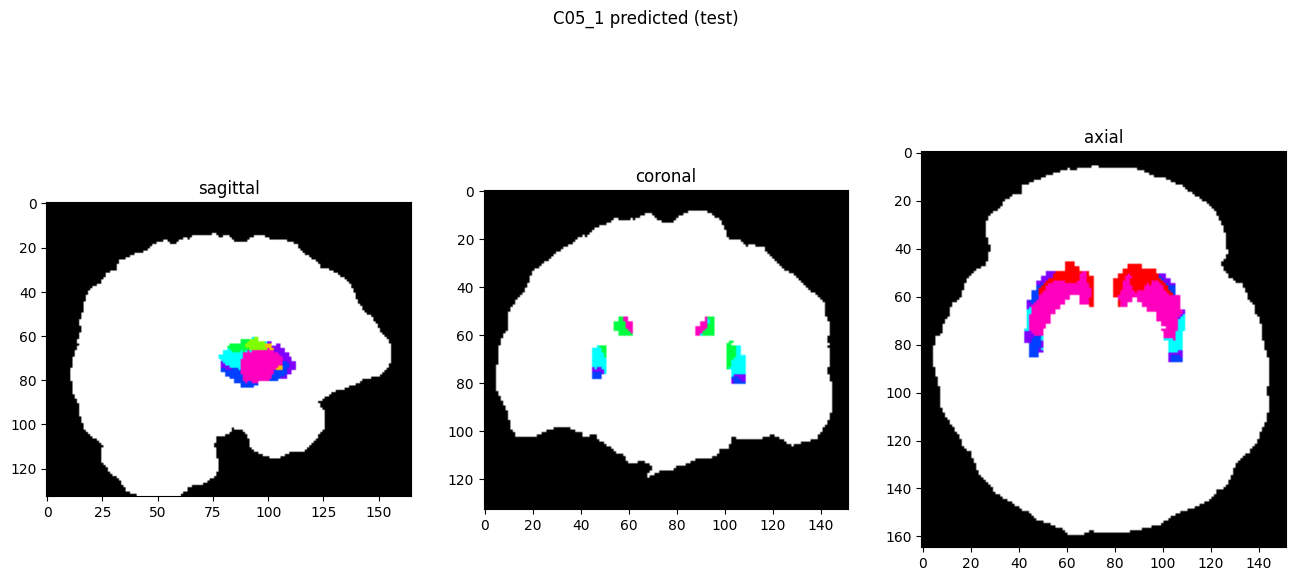

In [16]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)